# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [217]:
from google.colab import drive
drive.mount('/MIT_class')

Drive already mounted at /MIT_class; to attempt to forcibly remount, call drive.mount("/MIT_class", force_remount=True).


**Installing surprise library**

In [218]:
# Installing surprise library
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [219]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [220]:
col_names = ['user_id', 'prod_id', 'rating', 'timestamp']
df = pd.read_csv("/MIT_class/MyDrive/Colab_Notebooks/ratings_Electronics.csv", header=None, names=col_names)
df

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   prod_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [222]:
df = df.drop(columns=['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [223]:
# Step 1: Filter users with 50+ reviews

user_counts = df.groupby('user_id')['rating'].count()

filtered_users = df[df['user_id'].isin(user_counts[user_counts >= 50].index)]
filtered_users

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [224]:
# Filter out items with less than 5 reviews
item_counts = filtered_users.groupby('prod_id')['rating'].count()

filtered_items = filtered_users[filtered_users['prod_id'].isin(item_counts[item_counts >=5].index)]
filtered_items

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
...,...,...,...
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


In [225]:
df = filtered_items.copy()

In [226]:
# Print a few rows of the new dataset
df

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
...,...,...,...
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [227]:
# Check the number of rows and columns and provide observations
df.shape


(65290, 3)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [229]:
# rating distribution
df['rating'].value_counts()/df['rating'].count()

,count
rating,
5.0,0.556211
4.0,0.277638
3.0,0.099265
2.0,0.038520
1.0,0.028366


In [230]:
df['prod_id'].value_counts()

,count
prod_id,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149
...,...
B00368CDH6,5
B0036AZA6A,5
B0036E8V08,5


In [231]:
df['user_id'].value_counts()

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
...,...
A16CVJUQOB6GIB,2
A2BGZ52M908MJY,2
A3DL29NLZ7SXXG,1


__Brief Data Description__

***65,290 rows and three columns - user_id, prod_id, and rating**

***both ids are objects and ratings is a float**

***The ratings are on a 1 to 5 scale**

***There are 5,689 different items with over 5 ratings**

***There are 1,540 users with more than 50 ratings**

***No missing values**

### **Summary Statistics**

In [232]:
# Summary statistics of 'rating' variable and provide observations
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:rating is skewed to the left**

### **Checking the rating distribution**

<Axes: xlabel='rating', ylabel='Count'>

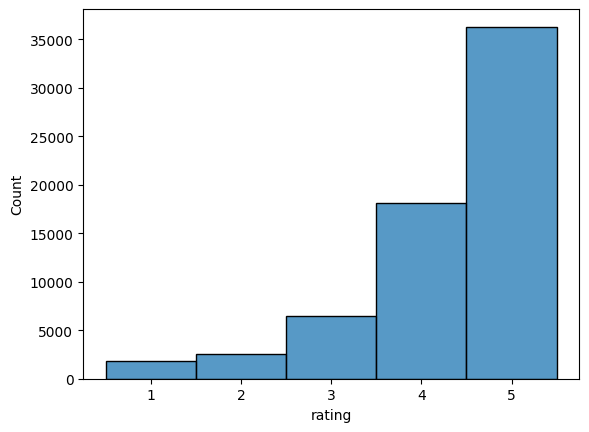

In [233]:
# Create the bar plot and provide observations
sns.histplot(data=df, x='rating', binwidth=1, discrete=True)

**55% of ratings are a five and another 30% are a 4, so about 85% of ratings are in the top two boxes.  One might consider grouping 1-3 and 4-5 five together and make a binary classification problem**

### **Checking the number of unique users and items in the dataset**

In [234]:
# Total number of unique users
unique_users = df['user_id'].nunique()
avg_interaction_user = len(df)/unique_users
print(unique_users)
print(round(avg_interaction_user, 3))

1540
42.396


In [235]:
# Total number of unique products
unique_prods = df['prod_id'].nunique()
avg_interactions_prods = len(df)/unique_prods
print(unique_prods)
print(round(avg_interactions_prods, 3))

5689
11.477


In [236]:
# Calculate sparsity
sparsity = (len(df)/(unique_prods * unique_users)) * 100
print(sparsity)

0.7452294585358393


In [237]:
#row and column count
df.shape

(65290, 3)

**There are 65290 total rows.  1540 unique users and 5689 unique items**

**Total users x Total Items = 1540 x 5689 = 8,756,660**

**Actual rows or interactions are 65,290**

**Sparsity = 65,290/8,756,660 = 0.75%**

**The low sparsity might give us a cold start challenge**

**Average interactions per user = 65290/1540 = 42.3 interactions per user**

**Average interactions per item = 65290/5689 = 11.5 interactions per user**


### **Users with the most number of ratings**

In [238]:
# Top 10 users based on the number of ratings
user_sort = pd.DataFrame(df.groupby('user_id')['rating'].count())
top_10_users = user_sort.sort_values(by='rating', ascending=False)
top_10_users.head(10)

,rating
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


In [239]:
# Top 10 items based on the number of ratings
item_sort = pd.DataFrame(df.groupby('prod_id')['rating'].count())
top_10_items = item_sort.sort_values(by='rating', ascending=False)
top_10_items.head(10)

,rating
prod_id,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149
B00829THK0,137
B008DWCRQW,137
B002R5AM7C,128
B004CLYEDC,118


<Axes: xlabel='rating', ylabel='Count'>

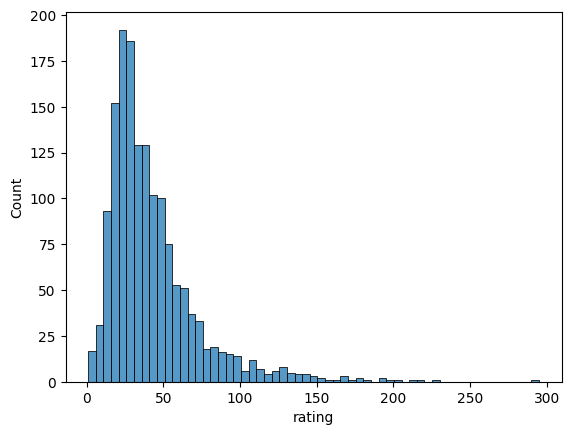

In [240]:
#User rating count distribution
sns.histplot(data=user_sort, x='rating')

**There is a tail for reviews 100+**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [241]:
# Calculate the average rating for each product
avg_rating = df.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':avg_rating, 'count_rating':count_rating})

# Sort the dataframe by average of ratings in the descending order and show the top 5
final_rating = final_rating.sort_values(by='avg_rating', ascending=False).head(5)

final_rating

,avg_rating,count_rating
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [242]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prods(data, n, min_interaction=50):

    # Finding books with minimum number of interactions
    recommendations = data[data['count_rating'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

res = list(top_n_prods(final_rating, 5, 4))

list_of_prods = []
for i in res:
    list_of_prods.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])

list_of_prods

['B00LGQ6HL8', 'B003DZJQQI', 'B005FDXF2C', 'B00I6CVPVC', 'B00B9KOCYA']

**Top 5 products based on 50+ interactions**

**B00LGQ6HL8, B003DZJQQI, B005FDXF2C, B00I6CVPVC, B00B9KOCYA**

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [243]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prods(data, n, min_interaction=100):

    # Finding books with minimum number of interactions
    recommendations = data[data['count_rating'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]


res = list(top_n_prods(final_rating, 5, 4))

list_of_prods = []
for i in res:
    list_of_prods.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])

list_of_prods

['B00LGQ6HL8', 'B003DZJQQI', 'B005FDXF2C', 'B00I6CVPVC', 'B00B9KOCYA']

**Top 5 products based on 100+ interactions**

**B00LGQ6HL8, B003DZJQQI, B005FDXF2C, B00I6CVPVC, B00B9KOCYA**

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [244]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [245]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [246]:
# create the final rating df
final_rating = pd.DataFrame({'avg_rating':avg_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [247]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [248]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_user)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**RMSE was 1.026 so our estimated average is about 1 point off within our five point scale.  Thus, about 95% of the actual values would fall between +/-1 of the predicted value**

**Precision is 0.844 which means that out of every 100 recommended items, about 84 were relevant. In other words, 84% of the recommended items were relevant to the user**

**Recall is 0.862 which means that out of every 100 relevant items, about 86 were recommended.  In other words, the model recommended about 86% of the relevant items to the use**

**The F_1 is the combination of both precision and recall and at 0.85% it suggests we have good balance between precision and recall**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [249]:
# Predicting rating for a sample user with an interacted product
knn_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**The user rated item 1400501466 a 5 and the model estimated 3.3, which is below the threshold of 3.5 and outside the RMSE**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [250]:
# Find unique user_id where prod_id is not equal to "1400501466"

#select all rows from df where they are not equal to "1400501466"
df_filter = df[df['prod_id'] != '1400501466']

#Filter on user_id "A34BZM6S9L7QI4" to confirm he has not seen "1400501466"
df_user_id = df_filter[df_filter['user_id'] == "A34BZM6S9L7QI4"]
df_user_id

,user_id,prod_id,rating
1161052,A34BZM6S9L7QI4,B000MDZKUU,5.0
1544021,A34BZM6S9L7QI4,B000ZH98LU,4.0
2821793,A34BZM6S9L7QI4,B002S53LJ2,5.0
2898610,A34BZM6S9L7QI4,B002VPE1Q6,5.0
2914885,A34BZM6S9L7QI4,B002WE6D44,5.0
...,...,...,...
7806778,A34BZM6S9L7QI4,B00J5174TU,5.0
7807176,A34BZM6S9L7QI4,B00J5DS8NE,5.0
7807280,A34BZM6S9L7QI4,B00J5HDEPC,3.0
7823885,A34BZM6S9L7QI4,B00KYMCJF8,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [251]:
# Predicting rating for a sample user with a non interacted product
knn_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**The model does not expect A34BZM6S9L7QI4 to like the product.  It is below the threshold and not expected to be relevant.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [252]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine','pearson'],
              'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9717150827406732
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [253]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_user_opt = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the trainset
knn_user_opt.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(knn_user_opt)


RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864


**The adjustments marginally improved scores. Recall showed the biggest improvement while Precision dropped by 0.01**

| Metrics  |knn_user |knn_user_opt|
|----------|---------|------------|
| RMSE     |  1.02   |   0.98     |
| Precision|  0.84   |   0.83     |  
| Recall   |  0.86   |   0.90     |
| F1       |  0.85   |   0.86     |

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [254]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
knn_user_opt.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [255]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
knn_user_opt.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**There was no difference for A3LDPF5FMB782Z for item 1400501466, but there was a significant improvement for A34BZM6S9L7QI4, who jumped from 1.9 to 4.3**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [256]:
# 0 is the inner id of the above user
knn_user_opt.get_neighbors(0, k=5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [257]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [258]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df, "A3LDPF5FMB782Z", 5, knn_user_opt)

In [259]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_Id', 'predicted_ratings'])

,prod_Id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [260]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item)

RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


The item-item method returned similar results vs. user-user

| Metrics  |knn_user |knn_user_opt|knn_item |
|----------|---------|------------|---------|
| RMSE     |  1.02   |     0.98   |  1.01   |
| Precision|  0.84   |     0.83   |  0.83   |  
| Recall   |  0.86   |     0.90   |  0.85   |
| F1       |  0.85   |     0.86   |  0.84   |

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [261]:
# Predicting rating for a sample user with an interacted product
knn_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**User A3LDPF5FMB782Z rated 1400501466 a 5.  The user-user method and user-user method optimized returned an estimate of 3.3 while the item-item returned an estimate of 4.3 which is much closer to the actual rating of 5**

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [262]:
# Predicting rating for a sample user with a non interacted product
knn_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**The item-item method returns an estimate of 4.0 which is similar to the user-user estimate of 4.3.  Both are above the 3.5 threshold which suggest that this is a relevant item for A34BZM6S9L7QI4**

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [263]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs_item.fit(data)

# Find the best RMSE score
print(gs_item.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs_item.best_params['rmse'])

0.9746090173682985
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [264]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_item_opt = KNNBasic(sim_options=sim_options, k=30, min_k=6, verbose=False)

# Training the algorithm on the trainset
knn_item_opt.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(knn_item_opt)

RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


**The performance metrics for user and item are very similar. Optimized versions of both user and item perform better than the non optimized methods**

| Metrics  |knn_user |knn_user_opt|knn_item |knn_item_opt|
|----------|---------|------------|---------|------------|
| RMSE     |  1.02   |     0.98   |  1.01   |   0.98     |
| Precision|  0.84   |     0.83   |  0.83   |   0.83     |
| Recall   |  0.86   |     0.90   |  0.85   |   0.89     |
| F1       |  0.85   |     0.86   |  0.84   |   0.86     |

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [265]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
knn_item_opt.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.62   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [266]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
knn_item_opt.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**The optimized item-item estimate for user A3LDPF5FMB782Z was 4.62 which is the closest to their actual 5 rating.  For user A34BZM6S9L7QI4 the item_item optimized returns the same rating as user-user optimized. The rating estimate does suggest this is a relevant items for user A34BZM6S9L7QI4**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [267]:
knn_item_opt.get_neighbors(0, k=5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [268]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, "A1A5KUIIIHFF4U", 5, knn_item_opt)

In [269]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_Id', 'predicted_ratings'])

,prod_Id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [270]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


**SVD did marginally outperform the collaborative filtering methods. The biggest improvement was the RMSE which is 0.07 better than both the optimized models**

| Metrics  |knn_user |knn_user_opt|knn_item |knn_item_opt|  svd  |
|----------|---------|------------|---------|------------|-------|
| RMSE     |  1.02   |     0.98   |  1.01   |   0.98     |  0.91 |
| Precision|  0.84   |     0.83   |  0.83   |   0.83     |  0.84 |
| Recall   |  0.86   |     0.90   |  0.85   |   0.89     |  0.88 |
| F1       |  0.85   |     0.86   |  0.84   |   0.86     |  0.86 |

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [271]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.094312160755627, details={'was_impossible': False})

**User A3LDPF5FMB782Z rated 1400501466 a 5.  Applying the svd model, it estimates 4.1, which suggests, like the versions above that this is a relevant item**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [272]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.05   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**All version except the initial user-user rate 1400501466 above the threshhold for A34BZM6S9L7QI4.  This is a relevant item for use A34BZM6S9L7QI4 and should be recommened to them**

###**Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [273]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_vsd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_vsd.fit(data)

# Best RMSE score
print(gs_vsd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_vsd.best_params['rmse'])

0.8995011067926147
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [274]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_opt = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_opt=svd_opt.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_opt)

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86


**SVD optimized performed very similarly to SVD**

|Metrics|knn_user|knn_user_opt|knn_item|knn_item_opt| svd  |svd_opt|
|-------|--------|------------|--------|------------|------|-------|
| RMSE  |  1.02  |     0.98   |  1.01  |   0.98     |0.91  |0.90   |
| Prec  |  0.84  |     0.83   |  0.83  |   0.83     |0.84  |0.84   |
| Recall|  0.86  |     0.90   |  0.85  |   0.89     |0.88  |0.88   |
| F1    |  0.85  |     0.86   |  0.84  |   0.86     |0.86  |0.86   |

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [275]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_opt.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.090441179731308, details={'was_impossible': False})

In [276]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_opt.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.06446285064312, details={'was_impossible': False})

**Like the vast majority of options above, the svd optimized model expects user A3LDPF5FMB782Z to rate it a 4.1. This shows item 1400501466 is relevant and aligns with their rating of 5.**

**For user A34BZM6S9L7QI4 who has not interacted with item 1400501466, the model estimates this will be a relevant item and should be recommended**

### **Conclusion and Recommendations**

**There where three different types of user recommendation models tested - user-user, item-item, and svd.  And each version used grid search to find the optimal hyperparameters for each**

**Of the three non optimized versions, svd performed the best, followed by item-item, and then user-user.**

**The optimized versions for user-user and item-item performed better than the non-optimized versions.  For svd, the optimized and non-optimized performed the same. Examining the three optimized versions, svd was the best and user-user and item-item were a dead heat**

|Metrics|knn_user|knn_user_opt|knn_item|knn_item_opt| svd  |svd_opt|
|-------|--------|------------|--------|------------|------|-------|
| RMSE  |  1.02  |     0.98   |  1.01  |   0.98     |0.91  |0.90   |
| Prec  |  0.84  |     0.83   |  0.83  |   0.83     |0.84  |0.84   |
| Recall|  0.86  |     0.90   |  0.85  |   0.89     |0.88  |0.88   |
| F1    |  0.85  |     0.86   |  0.84  |   0.86     |0.86  |0.86   |


**When reviewing the individual rating estimates, the first user-user model performed poorly. The user rated the item a 5 but the model estimated a 3.3 rating, which is below the threshold. All of other models performed similarly, rating the item a 4 or higher. All exceeding the 3.5 threshold which suggests that the models were good at selecting items that were relevant to the user and should be recommended.**